# Classificação de imagem com TensorFlow

Necessário python 3.6.x - 3.9.x

In [37]:
# Instalar dependências
# !pip install matplotlib
# !pip install numpy
# !pip install tensorflow
# !pip install pillow

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [39]:
# Defina alguns parâmetros para o carregador:
batch_size = 32
img_height = 180
img_width = 180

In [40]:
# Carregar o conjunto de dados
data_dir = "massa_dados/treino"

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=1,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 40 files belonging to 2 classes.
Using 32 files for training.


In [41]:
# Classes
class_names = train_ds.class_names
print("Classes:", class_names)

Classes: ['cachorros', 'gatos']


In [42]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=2,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 40 files belonging to 2 classes.
Using 8 files for validation.


In [43]:
# Classes 
class_names = val_ds.class_names
print("Classes:", class_names)

Classes: ['cachorros', 'gatos']


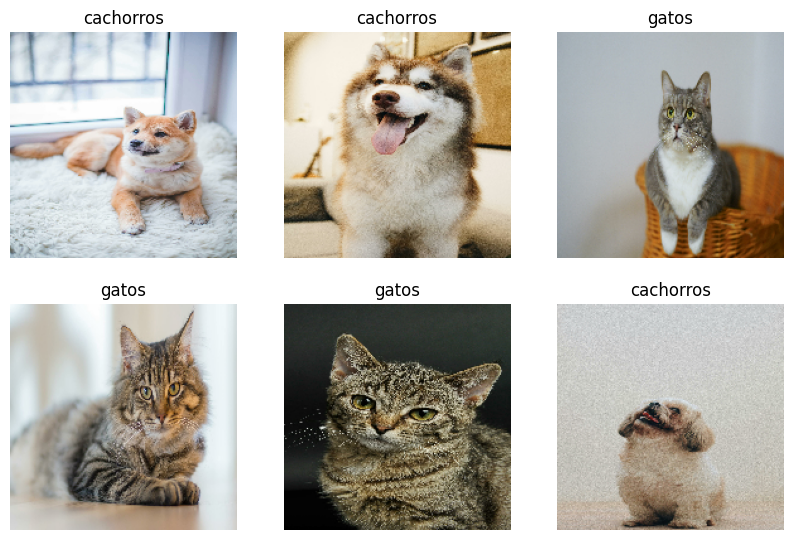

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [45]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [46]:
# Ajuste de performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Padronize os dados
Os valores do canal RGB estão na faixa [0, 255] . Isso não é ideal para uma rede neural; em geral, você deve procurar tornar seus valores de entrada pequenos.

Aqui, você padronizará os valores para estarem no intervalo [0, 1] usando tf.keras.layers.Rescaling

In [47]:
normalization_layer = layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9698455


# Modelo

O modelo Sequencial consiste em três blocos de convolução ( tf.keras.layers.Conv2D ) com uma camada de agrupamento máximo ( tf.keras.layers.MaxPooling2D ) em cada um deles. Há uma camada totalmente conectada ( tf.keras.layers.Dense ) com 128 unidades em cima dela que é ativada por uma função de ativação ReLU ( 'relu' ). Este modelo não foi ajustado para alta precisão - o objetivo deste tutorial é mostrar uma abordagem padrão.
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [48]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dropout(0.5),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

/Users/leonardojdss/Desktop/projetos/classification-image-tensorflow/.venv/lib/python3.9/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# Compilar Modelo

In [49]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [50]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_5 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 180, 180, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 90, 90, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 90, 90, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,004,066 (15.27 MB)

 Trainable params: 4,004,066 (15.27 MB)

 Non-trainable params: 0 (0.00 B)

# Treinamento

In [51]:
epochs=15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5000 - loss: 0.7046 - val_accuracy: 0.3750 - val_loss: 1.0705
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.5938 - loss: 0.8211 - val_accuracy: 0.6250 - val_loss: 0.6922
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - accuracy: 0.4062 - loss: 0.8790 - val_accuracy: 0.6250 - val_loss: 0.6479
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.4062 - loss: 0.7112 - val_accuracy: 0.3750 - val_loss: 0.7263
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.5938 - loss: 0.6596 - val_accuracy: 0.3750 - val_loss: 0.7995
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.5938 - loss: 0.6733 - val_accuracy: 0.3750 - val_loss: 0.7397
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.5938 - loss: 0.6352 - val_accuracy: 0.3750 - val_loss: 0.6616
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.6562 - loss: 0.5970 - val_accuracy: 0.6250 - val_loss: 0.

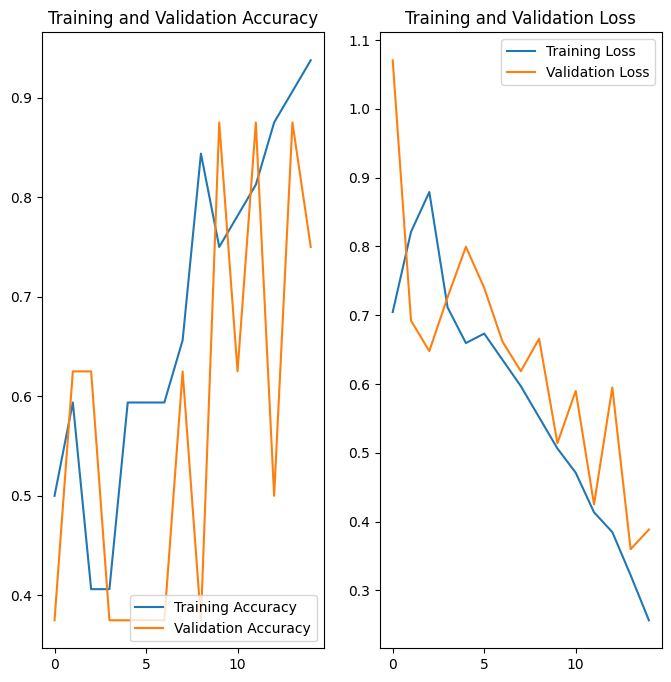

In [52]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [55]:
image_path = "imagens-teste/cachorro.png"

img = tf.keras.utils.load_img(
    image_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
This image most likely belongs to cachorros with a 73.26 percent confidence.
